# Revised Phase 4: Mitigation Experiments

**Objective**: Improve performance on 3-class (Negative, Neutral, Positive) sentiment classification on the Bangla Sentiment Dataset by applying imbalanced learning strategies, including data-level (SMOTE, Random Undersampling, NearMiss) and algorithm-level (Weighted Loss) methods. Train and tune Logistic Regression, SVM, Naive Bayes, and Random Forest, with comprehensive evaluations and visualizations (confusion matrices, ROC-AUC curves, precision-recall curves, F1 comparisons) to assess mitigation effectiveness.

In [2]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Define paths
data_dir = "text_representation/"
files = {
    'tfidf_train': f"{data_dir}tfidf_train.npz",
    'tfidf_val': f"{data_dir}tfidf_val.npz",
    'tfidf_test': f"{data_dir}tfidf_test.npz",
    'labels_train': f"{data_dir}labels_train.csv",
    'labels_val': f"{data_dir}labels_val.csv",
    'labels_test': f"{data_dir}labels_test.csv"
}

# Check file existence
for name, path in files.items():
    if not os.path.exists(path):
        logging.error(f"Missing file: {path}")
        raise FileNotFoundError(f"Missing file: {path}")

# Load TF-IDF matrices
tfidf_train = sp.load_npz(files['tfidf_train'])
tfidf_val = sp.load_npz(files['tfidf_val'])
tfidf_test = sp.load_npz(files['tfidf_test'])
logging.info("TF-IDF matrices loaded successfully")

# Load labels
y_train = pd.read_csv(files['labels_train'], encoding='utf-8')['Label'].values
y_val = pd.read_csv(files['labels_val'], encoding='utf-8')['Label'].values
y_test = pd.read_csv(files['labels_test'], encoding='utf-8')['Label'].values
logging.info("Labels loaded successfully")

# Validate shapes
assert tfidf_train.shape[0] == len(y_train), "Train data mismatch"
assert tfidf_val.shape[0] == len(y_val), "Validation data mismatch"
assert tfidf_test.shape[0] == len(y_test), "Test data mismatch"
logging.info("Data shapes validated")

# Print shapes and distribution
print("TF-IDF Train Shape:", tfidf_train.shape)
print("Labels Train Shape:", y_train.shape)
print("Label Distribution (Train):\n", pd.Series(y_train).value_counts(normalize=True) * 100)

2025-06-23 18:29:01,532 - INFO - TF-IDF matrices loaded successfully
2025-06-23 18:29:01,554 - INFO - Labels loaded successfully
2025-06-23 18:29:01,557 - INFO - Data shapes validated


TF-IDF Train Shape: (6193, 5000)
Labels Train Shape: (6193,)
Label Distribution (Train):
 0    47.359922
2    29.081221
1    23.558857
Name: proportion, dtype: float64


### Step 1: Apply Data-Level Mitigation Techniques

- **Objective**: Generate mitigated datasets using SMOTE (oversampling), Random Undersampling, and NearMiss (undersampling).

In [3]:
%pip install imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
import scipy.sparse as sp
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# SMOTE
smote = SMOTE(random_state=42)
tfidf_train_smote, y_train_smote = smote.fit_resample(tfidf_train, y_train)
sp.save_npz("mitigated_datasets/tfidf_train_smote.npz", tfidf_train_smote)
pd.DataFrame({'Label': y_train_smote}).to_csv("mitigated_datasets/labels_train_smote.csv", index=False)
logging.info("SMOTE dataset saved")

# Random Undersampling
undersampler = RandomUnderSampler(random_state=42)
tfidf_train_under, y_train_under = undersampler.fit_resample(tfidf_train, y_train)
sp.save_npz("mitigated_datasets/tfidf_train_undersampled.npz", tfidf_train_under)
pd.DataFrame({'Label': y_train_under}).to_csv("mitigated_datasets/labels_train_undersampled.csv", index=False)
logging.info("Undersampled dataset saved")

# NearMiss (version 1)
nearmiss = NearMiss(version=1, n_neighbors=3)
tfidf_train_nearmiss, y_train_nearmiss = nearmiss.fit_resample(tfidf_train, y_train)
sp.save_npz("mitigated_datasets/tfidf_train_nearmiss.npz", tfidf_train_nearmiss)
pd.DataFrame({'Label': y_train_nearmiss}).to_csv("mitigated_datasets/labels_train_nearmiss.csv", index=False)
logging.info("NearMiss dataset saved")

# Class weights for algorithm-level mitigation
class_weights = {i: 1.0 / pd.Series(y_train).value_counts()[i] for i in range(3)}
total = sum(class_weights.values())
class_weights = {k: v / total * 3 for k, v in class_weights.items()}
logging.info("Class weights computed")

2025-06-23 18:29:08,542 - INFO - SMOTE dataset saved
2025-06-23 18:29:08,615 - INFO - Undersampled dataset saved
2025-06-23 18:29:09,094 - INFO - NearMiss dataset saved
2025-06-23 18:29:09,099 - INFO - Class weights computed


### Step 2: Retrain Logistic Regression, SVM, Naive Bayes, and Random Forest

- **Objective**: Train models on mitigated datasets (SMOTE, Random Undersampling, NearMiss) and apply weighted loss to all models

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import joblib
from tqdm import tqdm
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Create output directory
os.makedirs("models/mitigated_models", exist_ok=True)
logging.info("Output directory created: models/mitigated_models")

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, penalty='l2', random_state=42),  # Removed deprecated multi_class
    'SVM': SVC(probability=True, random_state=42),
    'NaiveBayes': MultinomialNB(),
    'RandomForest': RandomForestClassifier(random_state=42)
}

# Define datasets
datasets = {
    'smote': (tfidf_train_smote, y_train_smote),
    'undersampled': (tfidf_train_under, y_train_under),
    'nearmiss': (tfidf_train_nearmiss, y_train_nearmiss),
    'weighted': (tfidf_train_smote, y_train_smote)  # Same data, but algorithm-level class_weight is applied
}

# Supported class_weight models
supports_class_weight = {'LogisticRegression', 'SVM', 'RandomForest'}

# Train models
for dataset_name, (X_train, y_train) in tqdm(datasets.items(), desc="Training Datasets"):
    for name, model in models.items():
        try:
            # Clone model to avoid contamination
            model_copy = model.__class__(**model.get_params())

            # Set class_weight only when applicable
            if dataset_name == 'weighted' and name in supports_class_weight:
                model_copy.set_params(class_weight=class_weights)
            elif 'class_weight' in model_copy.get_params():
                model_copy.set_params(class_weight=None)

            model_copy.fit(X_train, y_train)

            model_path = f"models/mitigated_models/{name}_{dataset_name}.joblib"
            joblib.dump(model_copy, model_path)
            logging.info(f"{name} ({dataset_name}) trained and saved")

        except Exception as e:
            logging.error(f"Error training {name} ({dataset_name}): {str(e)}")


2025-06-23 18:29:09,124 - INFO - Output directory created: models/mitigated_models
Training Datasets:   0%|          | 0/4 [00:00<?, ?it/s]2025-06-23 18:29:10,436 - INFO - LogisticRegression (smote) trained and saved
2025-06-23 18:30:59,090 - INFO - SVM (smote) trained and saved
2025-06-23 18:30:59,111 - INFO - NaiveBayes (smote) trained and saved
2025-06-23 18:31:18,355 - INFO - RandomForest (smote) trained and saved
Training Datasets:  25%|██▌       | 1/4 [02:09<06:27, 129.22s/it]2025-06-23 18:31:18,828 - INFO - LogisticRegression (undersampled) trained and saved
2025-06-23 18:31:45,447 - INFO - SVM (undersampled) trained and saved
2025-06-23 18:31:45,456 - INFO - NaiveBayes (undersampled) trained and saved
2025-06-23 18:31:57,343 - INFO - RandomForest (undersampled) trained and saved
Training Datasets:  50%|█████     | 2/4 [02:48<02:32, 76.14s/it] 2025-06-23 18:31:58,147 - INFO - LogisticRegression (nearmiss) trained and saved
2025-06-23 18:32:19,433 - INFO - SVM (nearmiss) trained 

### Step 3: Hyperparameter Tuning

- **Objective**: Tune Logistic Regression, SVM, Naive Bayes, and Random Forest on mitigated datasets.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from tqdm import tqdm
import joblib
import pandas as pd
import logging


param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'penalty': ['l2'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'rbf']
    },
    'NaiveBayes': {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],  # Prevent overfitting
    }
}
# Tune models
tuned_results = {}

for dataset_name, (X_train, y_train) in tqdm(datasets.items(), desc="Tuning Datasets"):
    for name, model in models.items():
        try:
            if dataset_name == 'weighted' and name in ['LogisticRegression', 'SVM']:
                model.set_params(class_weight=class_weights)
            grid = GridSearchCV(
                estimator=model,
                param_grid=param_grids[name],
                scoring='f1_weighted',
                cv=5,
                n_jobs=-1,
                verbose=1
            )
            grid.fit(X_train, y_train)
            tuned_results[f"{name}_{dataset_name}"] = {
                'best_params': grid.best_params_,
                'best_score': grid.best_score_
            }
            joblib.dump(grid.best_estimator_, f"models/mitigated_models/{name}_{dataset_name}_tuned.joblib")
            logging.info(f"{name} ({dataset_name}) tuned and saved: {grid.best_params_}")
        except Exception as e:
            logging.error(f"Error tuning {name} ({dataset_name}): {str(e)}")

# Save tuning results
pd.DataFrame(tuned_results).to_csv("models/mitigated_models/tuned_results.csv")
logging.info("Tuning results saved: tuned_results.csv")

Tuning Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025-06-23 18:52:47,168 - INFO - LogisticRegression (smote) tuned and saved: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-23 19:09:55,207 - INFO - SVM (smote) tuned and saved: {'C': 100, 'kernel': 'rbf'}


Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-06-23 19:09:55,524 - INFO - NaiveBayes (smote) tuned and saved: {'alpha': 0.01}


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-23 19:15:25,574 - INFO - RandomForest (smote) tuned and saved: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuning Datasets:  25%|██▌       | 1/4 [23:07<1:09:23, 1387.73s/it]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025-06-23 19:15:36,998 - INFO - LogisticRegression (undersampled) tuned and saved: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'sag'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-23 19:19:33,393 - INFO - SVM (undersampled) tuned and saved: {'C': 1, 'kernel': 'rbf'}
2025-06-23 19:19:33,602 - INFO - NaiveBayes (undersampled) tuned and saved: {'alpha': 1.0}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-23 19:23:17,664 - INFO - RandomForest (undersampled) tuned and saved: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Tuning Datasets:  50%|█████     | 2/4 [30:59<28:18, 849.12s/it]   

Fitting 5 folds for each of 24 candidates, totalling 120 fits


2025-06-23 19:23:32,246 - INFO - LogisticRegression (nearmiss) tuned and saved: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-23 19:27:23,896 - INFO - SVM (nearmiss) tuned and saved: {'C': 1, 'kernel': 'rbf'}
2025-06-23 19:27:24,027 - INFO - NaiveBayes (nearmiss) tuned and saved: {'alpha': 1.0}


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-23 19:30:26,248 - INFO - RandomForest (nearmiss) tuned and saved: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Tuning Datasets:  75%|███████▌  | 3/4 [38:08<10:57, 657.09s/it]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
2025-06-23 19:30:50,824 - INFO - LogisticRegression (weighted) tuned and saved: {'C': 100, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}


Fitting 5 folds for each of 12 candidates, totalling 60 fits


2025-06-23 19:46:33,609 - INFO - SVM (weighted) tuned and saved: {'C': 1000, 'kernel': 'rbf'}


Fitting 5 folds for each of 6 candidates, totalling 30 fits


2025-06-23 19:46:33,823 - INFO - NaiveBayes (weighted) tuned and saved: {'alpha': 0.01}


Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-23 19:52:33,397 - INFO - RandomForest (weighted) tuned and saved: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Tuning Datasets: 100%|██████████| 4/4 [1:00:15<00:00, 903.89s/it]
2025-06-23 19:52:33,487 - INFO - Tuning results saved: tuned_results.csv


### Step 4: Evaluate and Compare

- **Objective**: Evaluate mitigated models on test set, compare with Phase 3 baselines, and visualize performance, emphasizing Positive class with precision-recall curves.

Evaluating Models:   0%|          | 0/4 [00:00<?, ?it/s]2025-06-23 19:58:26,597 - INFO - Loaded model: LogisticRegression_smote_tuned.joblib


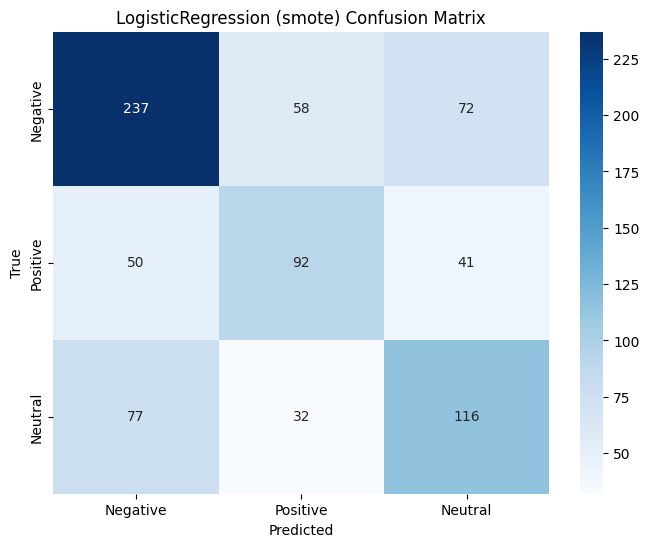

2025-06-23 19:58:26,918 - INFO - Saved confusion matrix: LogisticRegression_smote_cm.png


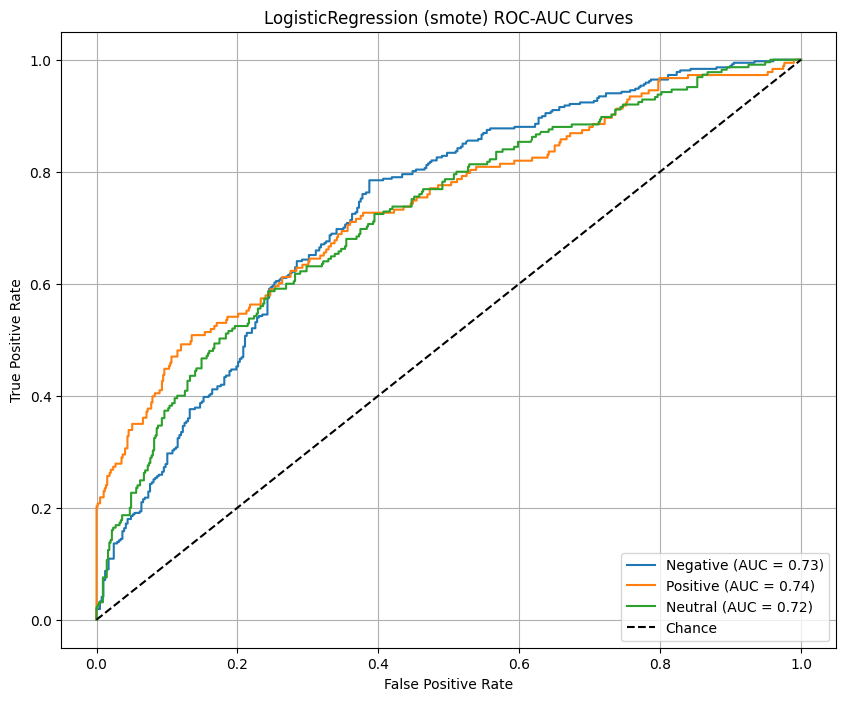

2025-06-23 19:58:27,318 - INFO - Saved ROC-AUC plot: LogisticRegression_smote_roc_auc.png


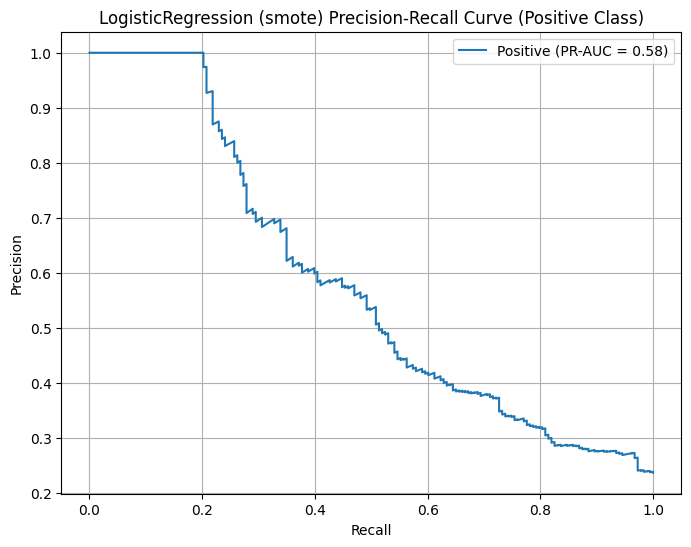

2025-06-23 19:58:27,608 - INFO - Saved PR curve: LogisticRegression_smote_pr_curve.png
2025-06-23 19:58:27,610 - INFO - Loaded model: LogisticRegression_undersampled_tuned.joblib


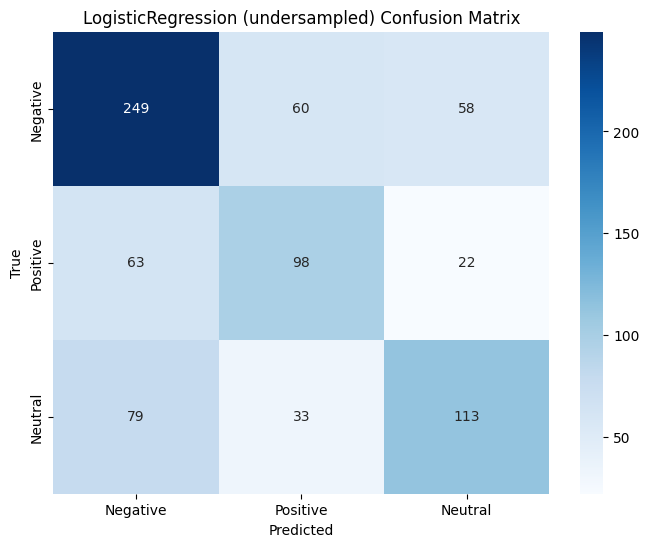

2025-06-23 19:58:27,861 - INFO - Saved confusion matrix: LogisticRegression_undersampled_cm.png


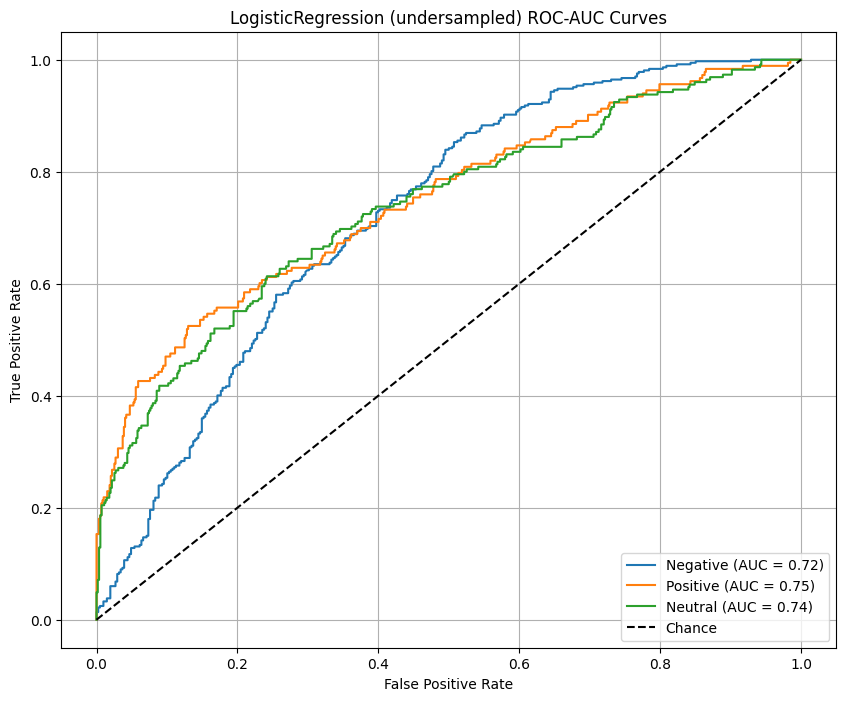

2025-06-23 19:58:28,168 - INFO - Saved ROC-AUC plot: LogisticRegression_undersampled_roc_auc.png


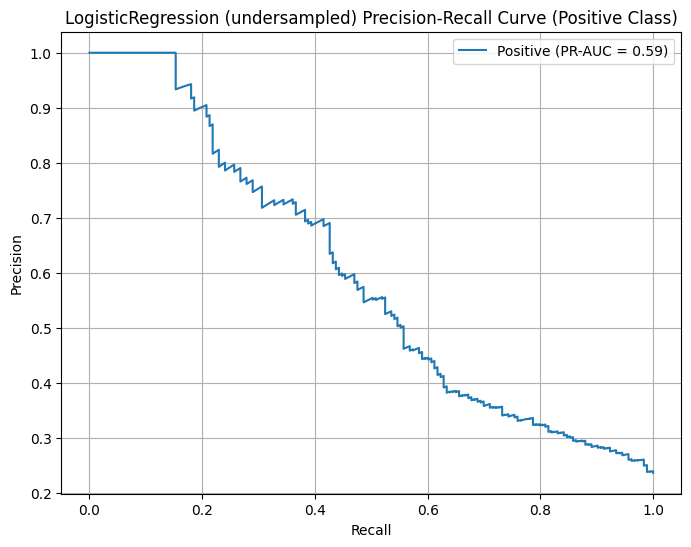

2025-06-23 19:58:28,454 - INFO - Saved PR curve: LogisticRegression_undersampled_pr_curve.png
2025-06-23 19:58:28,456 - INFO - Loaded model: LogisticRegression_nearmiss_tuned.joblib


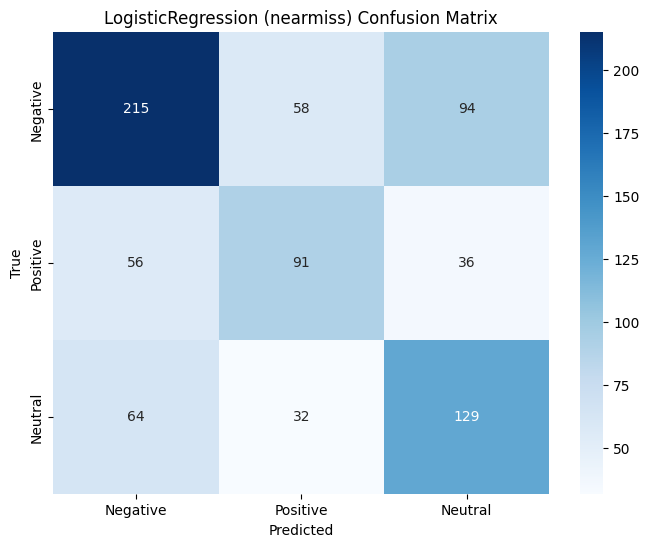

2025-06-23 19:58:28,701 - INFO - Saved confusion matrix: LogisticRegression_nearmiss_cm.png


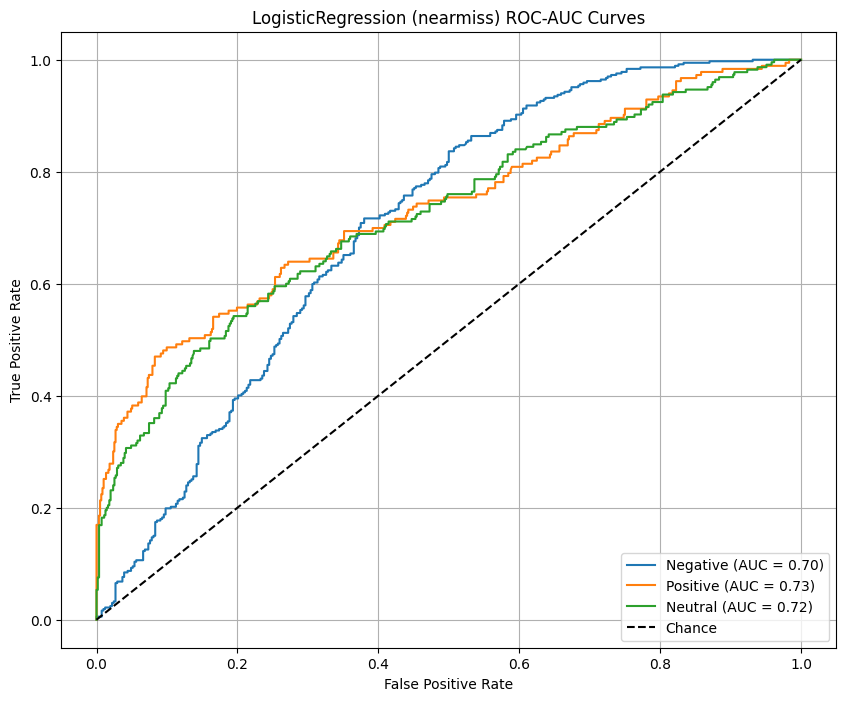

2025-06-23 19:58:29,016 - INFO - Saved ROC-AUC plot: LogisticRegression_nearmiss_roc_auc.png


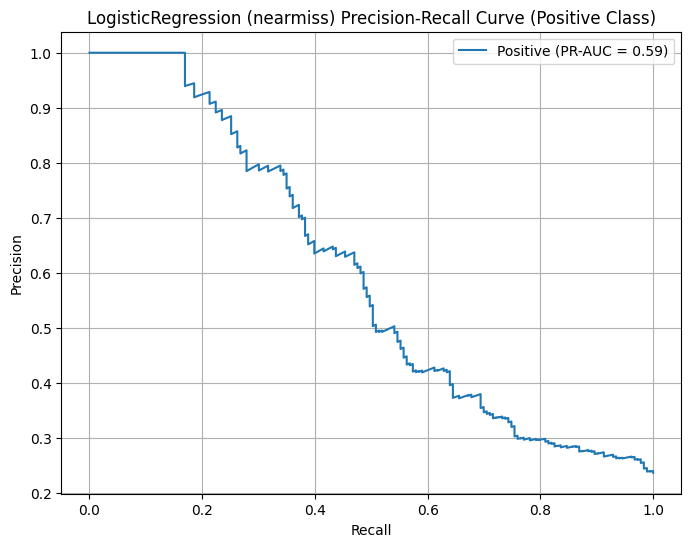

2025-06-23 19:58:29,257 - INFO - Saved PR curve: LogisticRegression_nearmiss_pr_curve.png
2025-06-23 19:58:29,260 - INFO - Loaded model: LogisticRegression_weighted_tuned.joblib


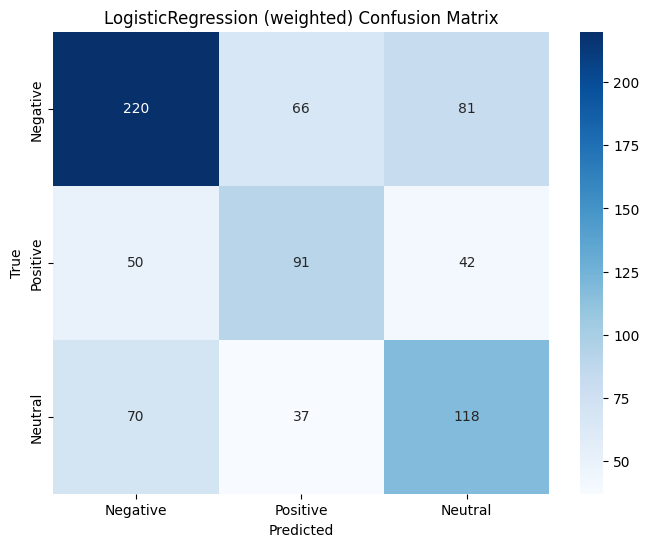

2025-06-23 19:58:29,505 - INFO - Saved confusion matrix: LogisticRegression_weighted_cm.png


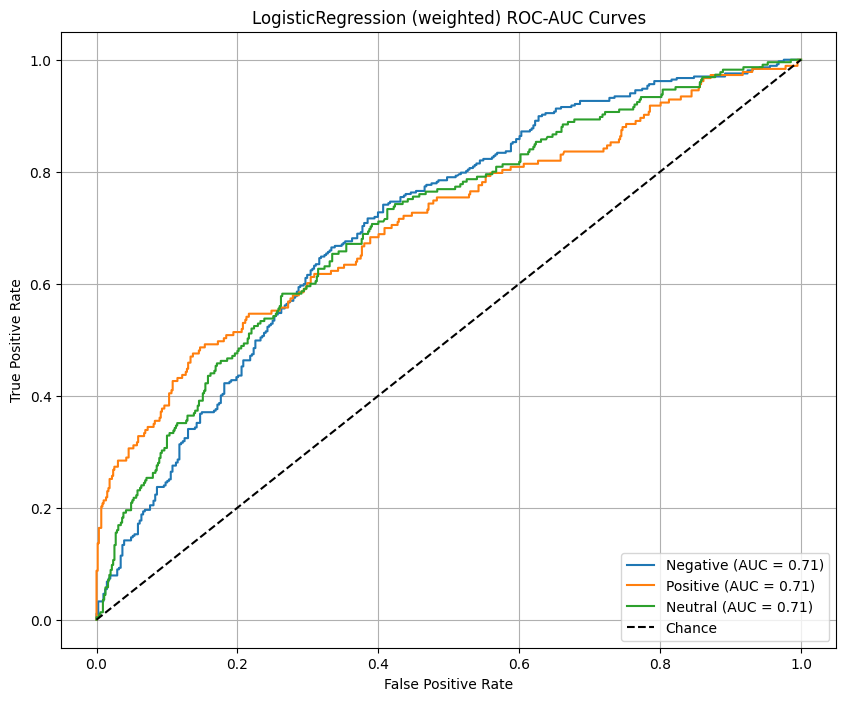

2025-06-23 19:58:29,956 - INFO - Saved ROC-AUC plot: LogisticRegression_weighted_roc_auc.png


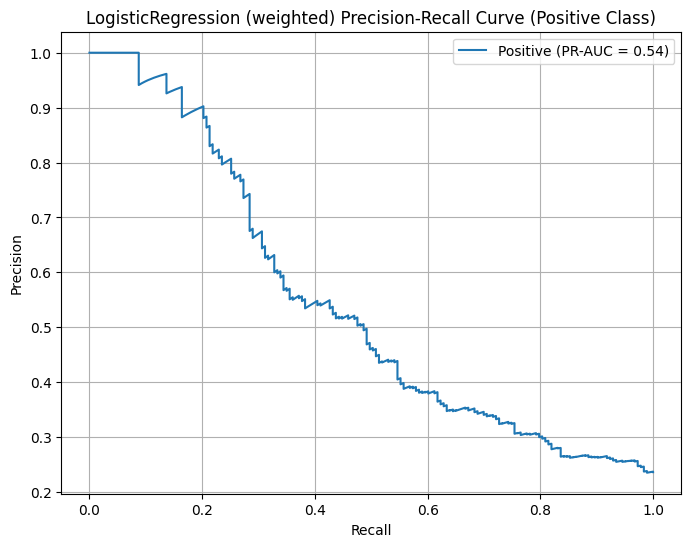

2025-06-23 19:58:30,219 - INFO - Saved PR curve: LogisticRegression_weighted_pr_curve.png
Evaluating Models:  25%|██▌       | 1/4 [00:03<00:10,  3.63s/it]2025-06-23 19:58:30,224 - INFO - Loaded model: SVM_smote_tuned.joblib


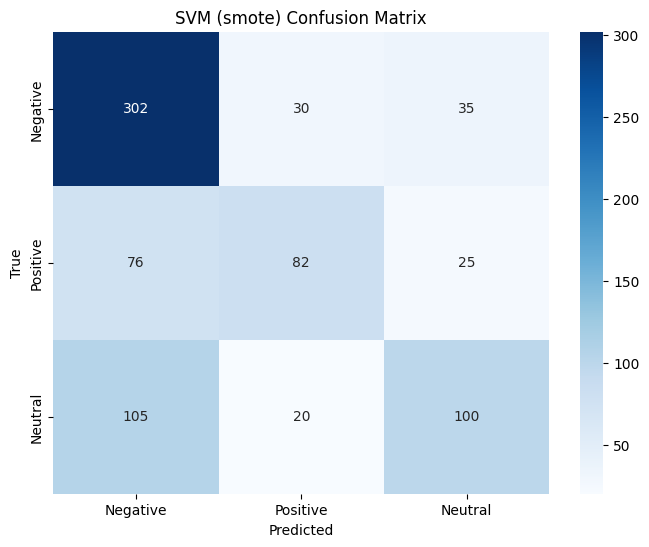

2025-06-23 19:58:31,547 - INFO - Saved confusion matrix: SVM_smote_cm.png


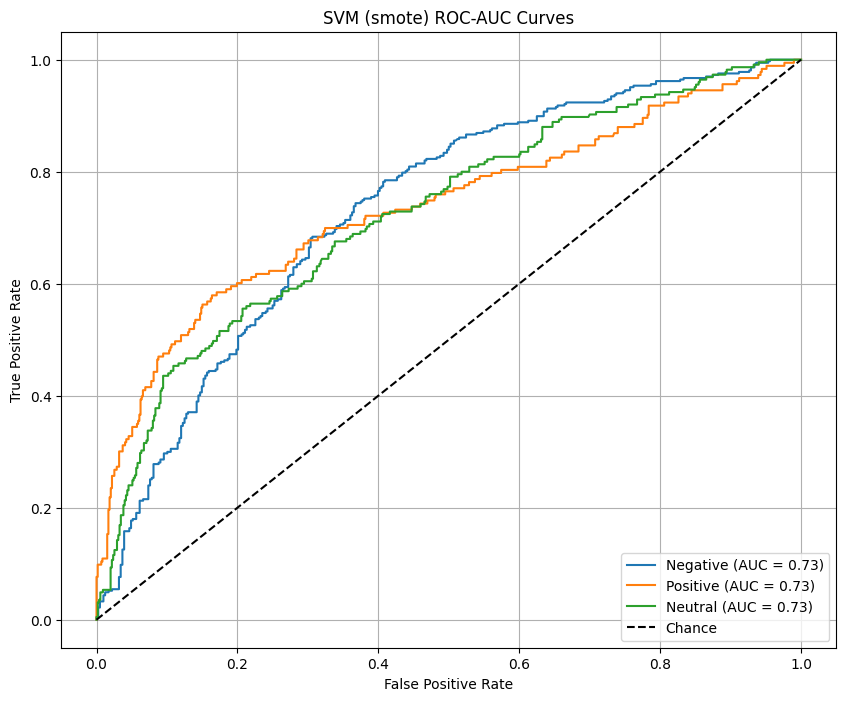

2025-06-23 19:58:31,850 - INFO - Saved ROC-AUC plot: SVM_smote_roc_auc.png


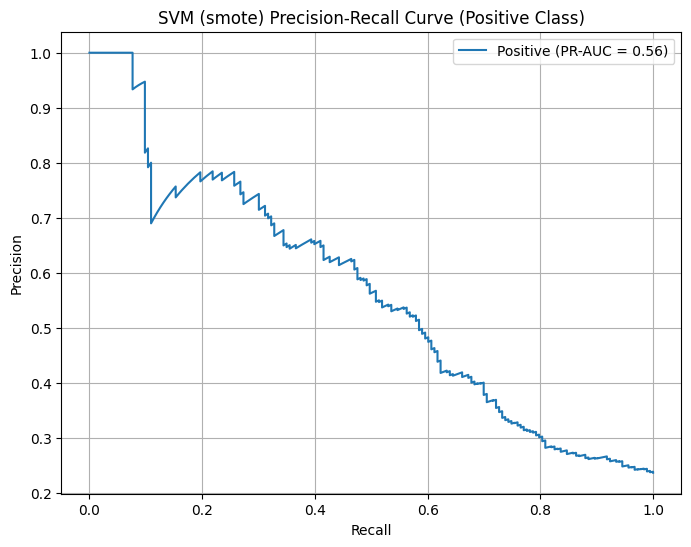

2025-06-23 19:58:32,109 - INFO - Saved PR curve: SVM_smote_pr_curve.png
2025-06-23 19:58:32,112 - INFO - Loaded model: SVM_undersampled_tuned.joblib


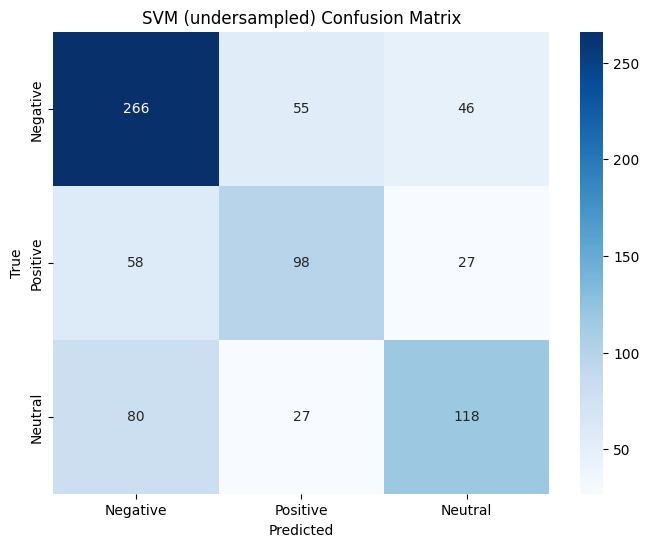

2025-06-23 19:58:32,994 - INFO - Saved confusion matrix: SVM_undersampled_cm.png


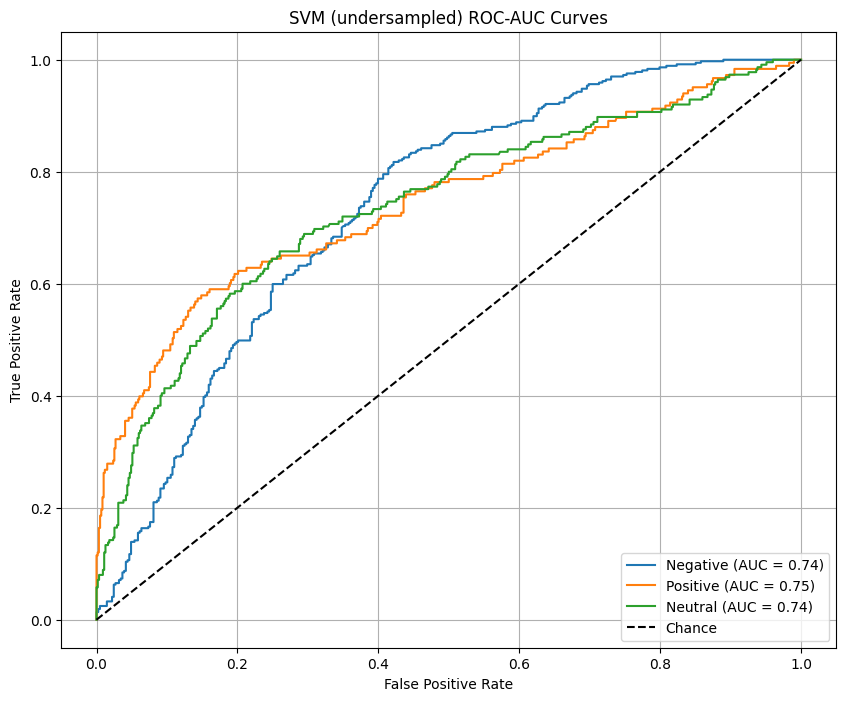

2025-06-23 19:58:33,315 - INFO - Saved ROC-AUC plot: SVM_undersampled_roc_auc.png


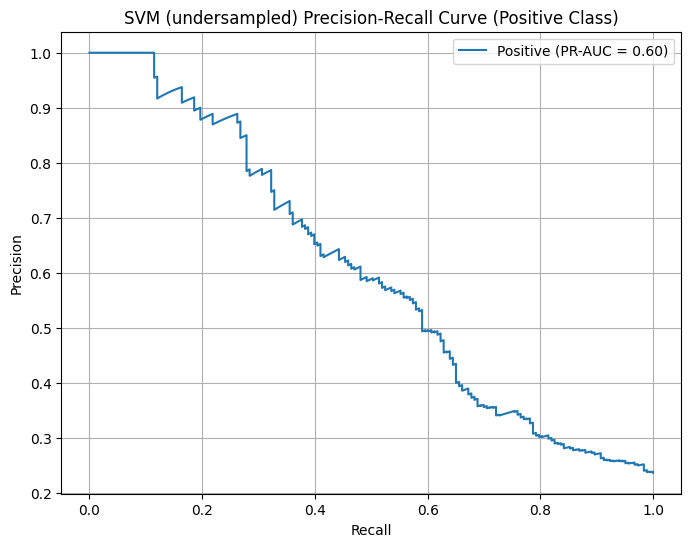

2025-06-23 19:58:33,605 - INFO - Saved PR curve: SVM_undersampled_pr_curve.png
2025-06-23 19:58:33,610 - INFO - Loaded model: SVM_nearmiss_tuned.joblib


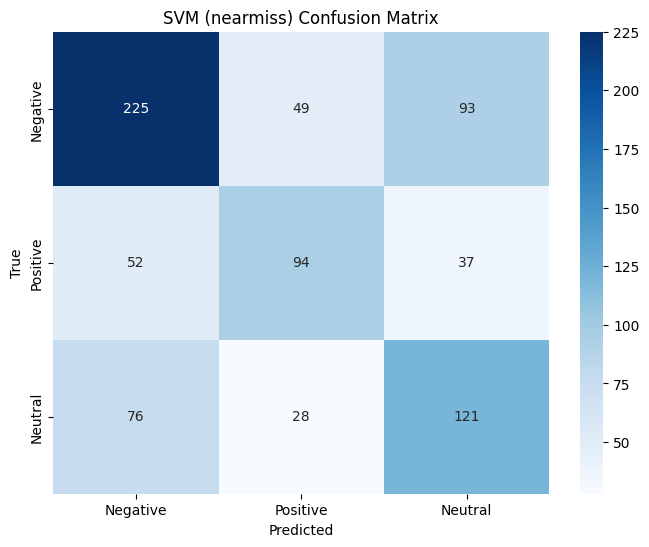

2025-06-23 19:58:34,663 - INFO - Saved confusion matrix: SVM_nearmiss_cm.png


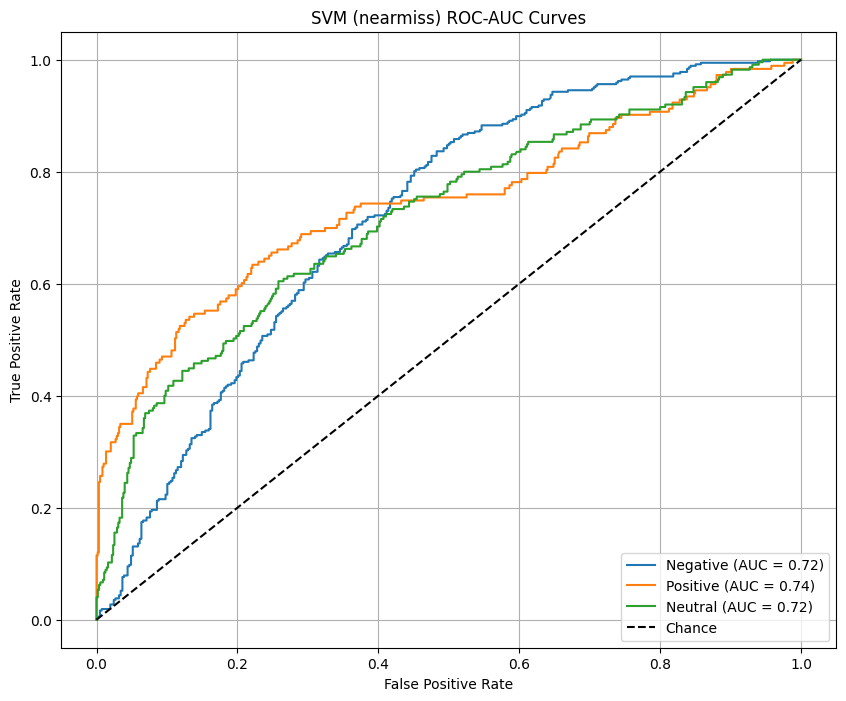

2025-06-23 19:58:34,992 - INFO - Saved ROC-AUC plot: SVM_nearmiss_roc_auc.png


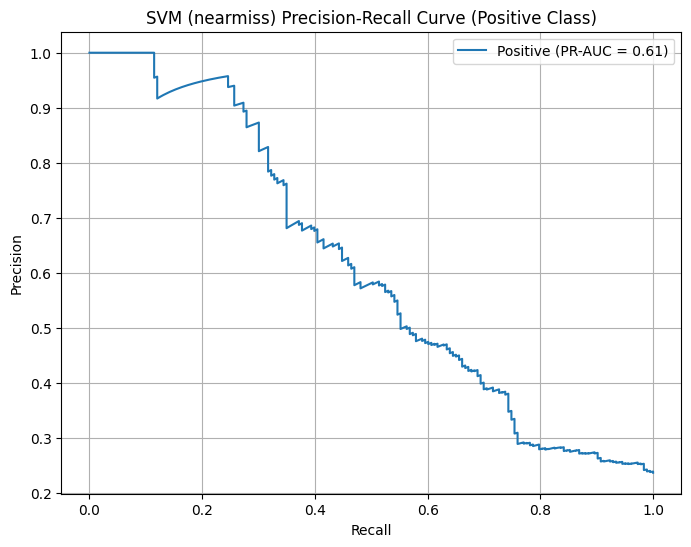

2025-06-23 19:58:35,279 - INFO - Saved PR curve: SVM_nearmiss_pr_curve.png
2025-06-23 19:58:35,283 - INFO - Loaded model: SVM_weighted_tuned.joblib


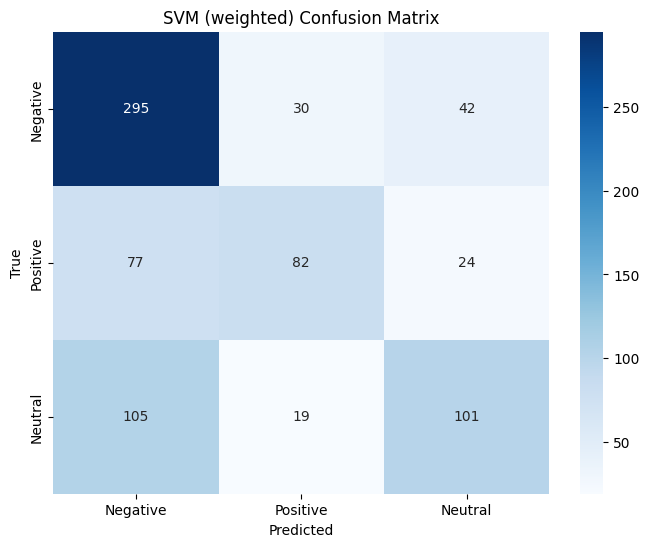

2025-06-23 19:58:36,798 - INFO - Saved confusion matrix: SVM_weighted_cm.png


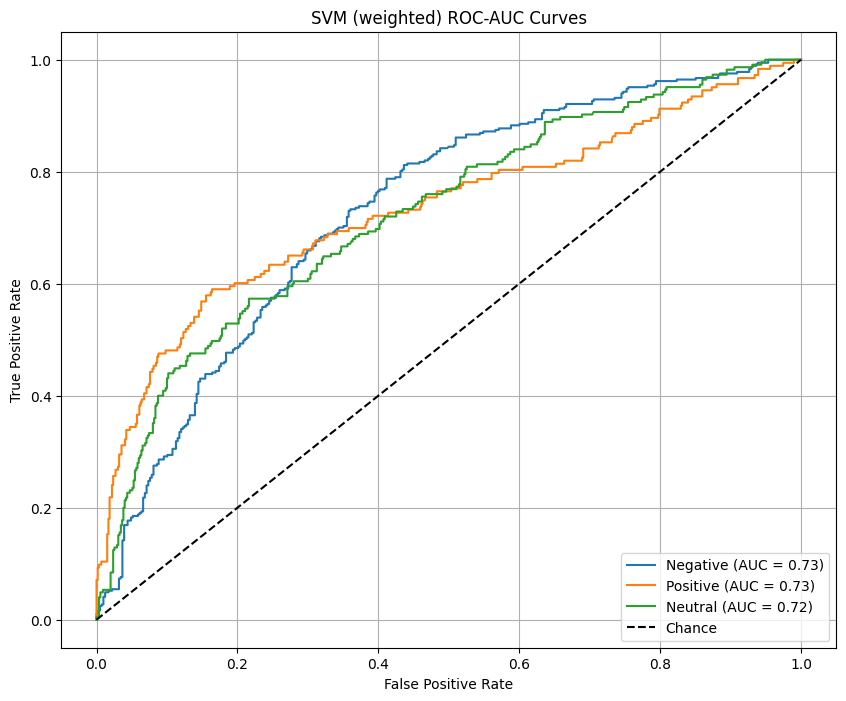

2025-06-23 19:58:37,168 - INFO - Saved ROC-AUC plot: SVM_weighted_roc_auc.png


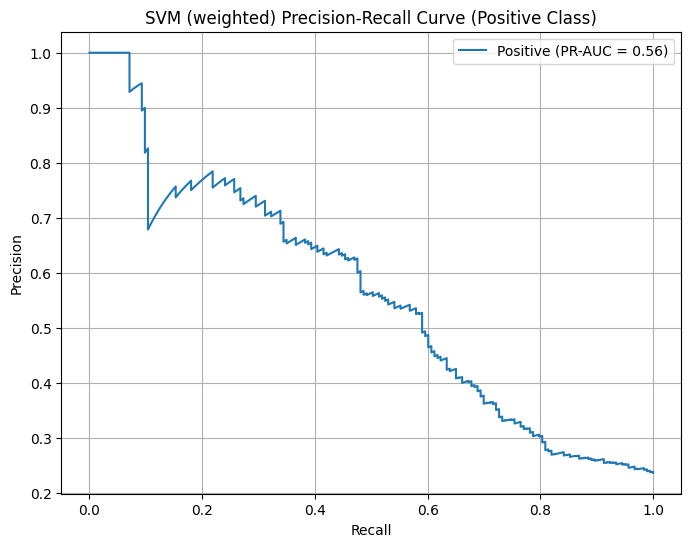

2025-06-23 19:58:37,634 - INFO - Saved PR curve: SVM_weighted_pr_curve.png
Evaluating Models:  50%|█████     | 2/4 [00:11<00:11,  5.86s/it]2025-06-23 19:58:37,638 - INFO - Loaded model: NaiveBayes_smote_tuned.joblib


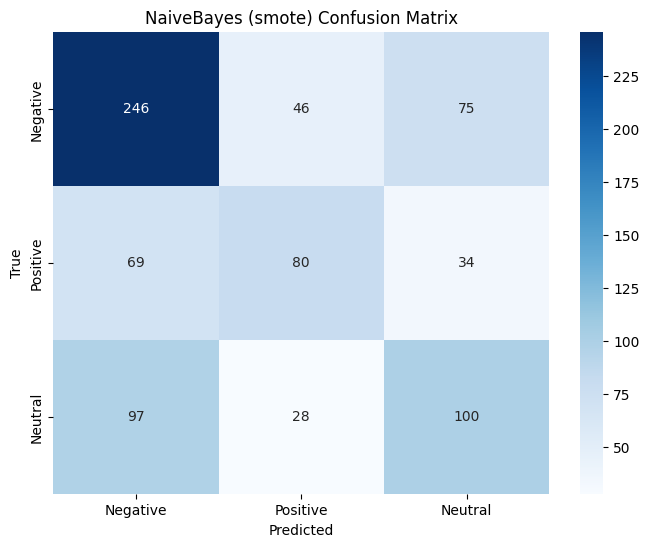

2025-06-23 19:58:38,022 - INFO - Saved confusion matrix: NaiveBayes_smote_cm.png


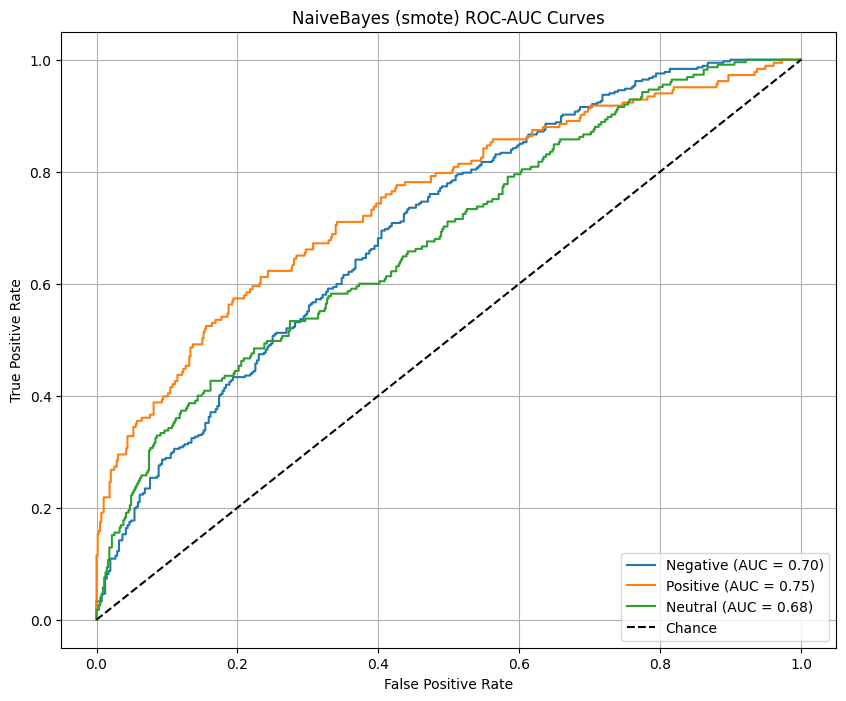

2025-06-23 19:58:38,456 - INFO - Saved ROC-AUC plot: NaiveBayes_smote_roc_auc.png


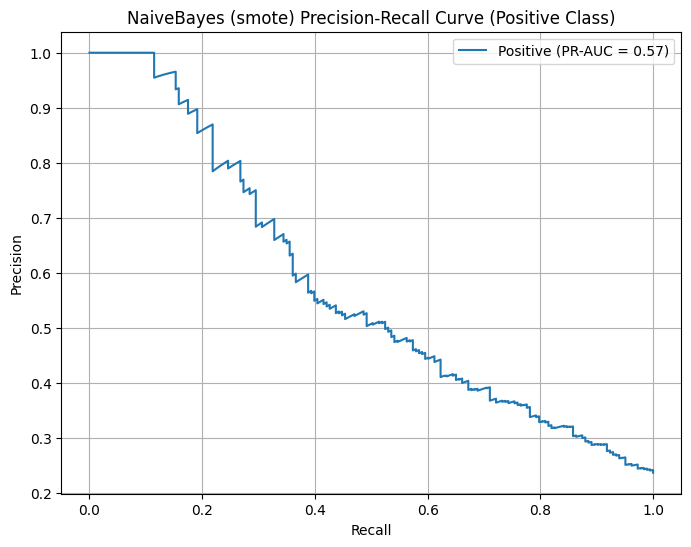

2025-06-23 19:58:38,834 - INFO - Saved PR curve: NaiveBayes_smote_pr_curve.png
2025-06-23 19:58:38,838 - INFO - Loaded model: NaiveBayes_undersampled_tuned.joblib


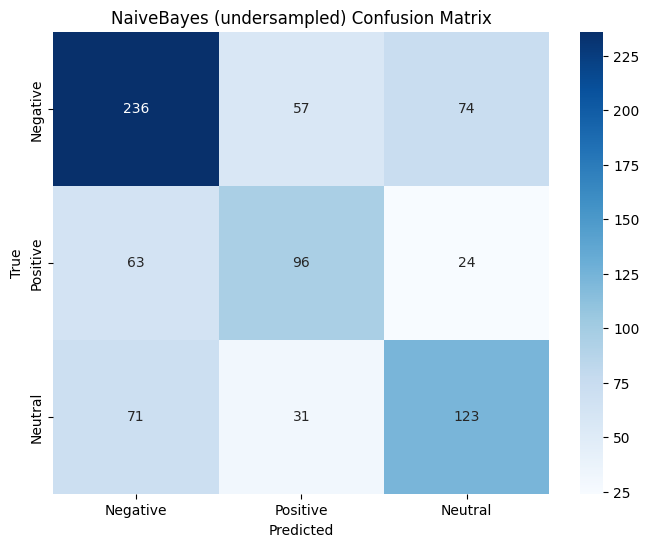

2025-06-23 19:58:39,386 - INFO - Saved confusion matrix: NaiveBayes_undersampled_cm.png


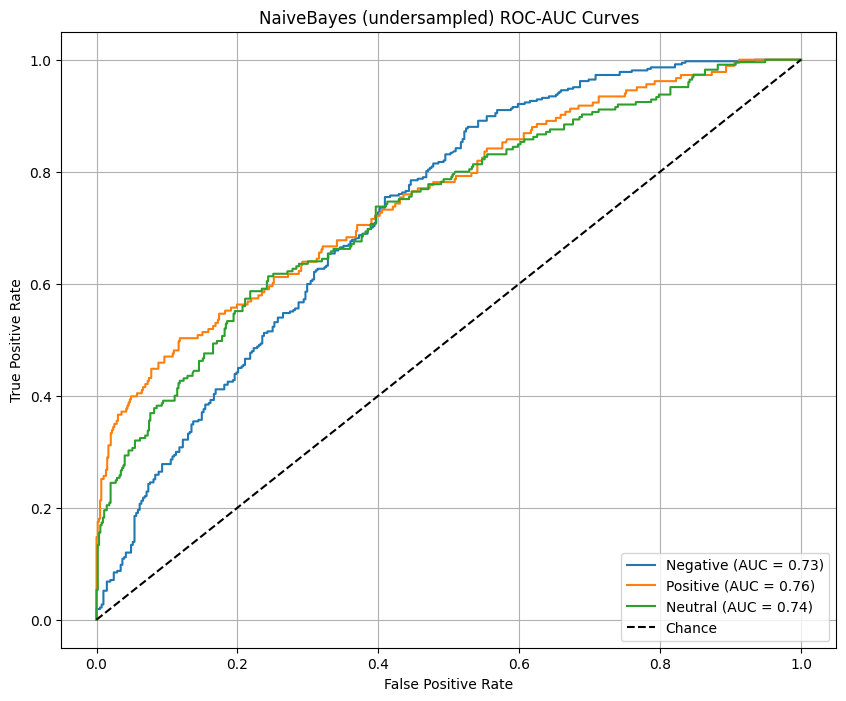

2025-06-23 19:58:39,810 - INFO - Saved ROC-AUC plot: NaiveBayes_undersampled_roc_auc.png


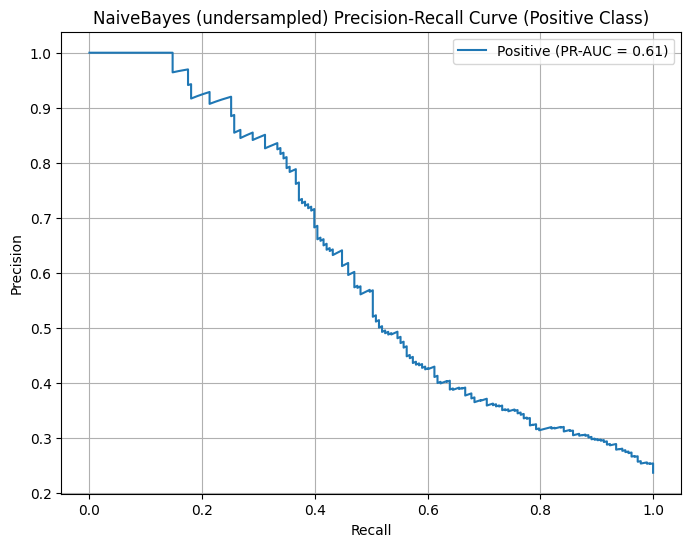

2025-06-23 19:58:40,246 - INFO - Saved PR curve: NaiveBayes_undersampled_pr_curve.png
2025-06-23 19:58:40,250 - INFO - Loaded model: NaiveBayes_nearmiss_tuned.joblib


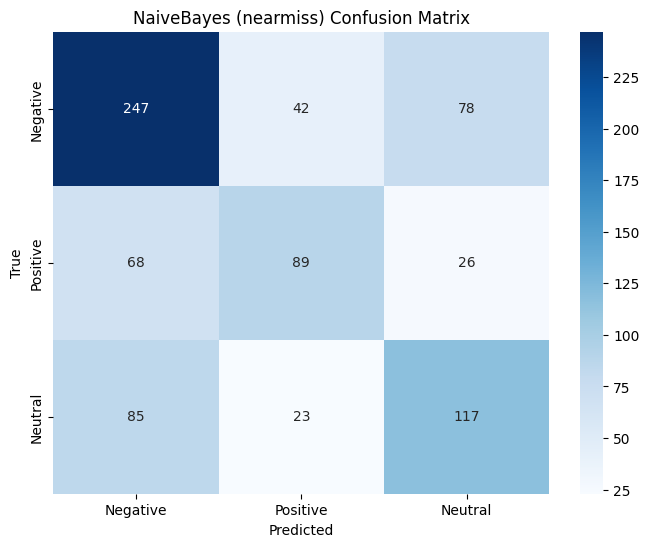

2025-06-23 19:58:40,827 - INFO - Saved confusion matrix: NaiveBayes_nearmiss_cm.png


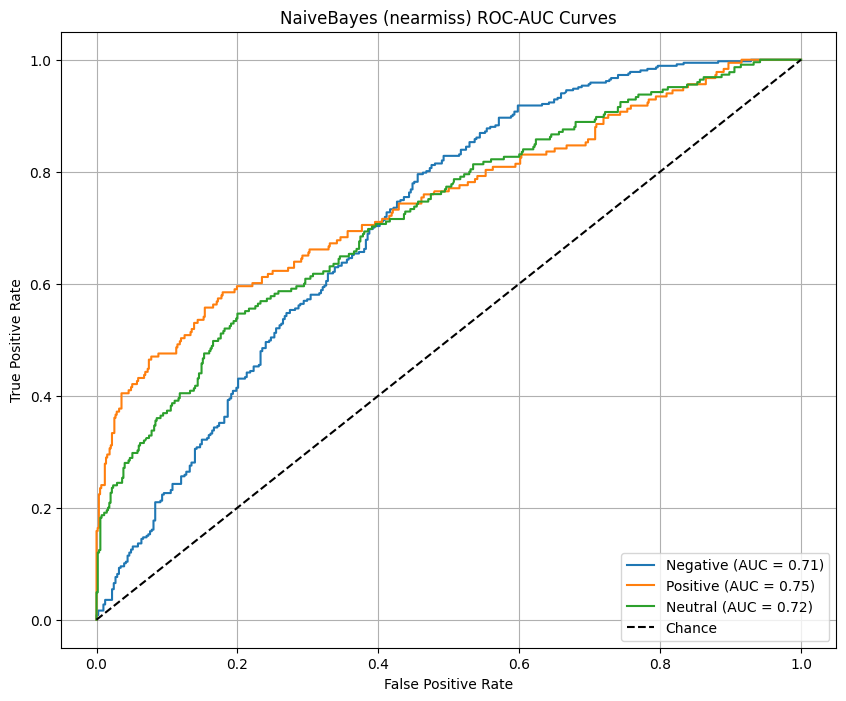

2025-06-23 19:58:41,312 - INFO - Saved ROC-AUC plot: NaiveBayes_nearmiss_roc_auc.png


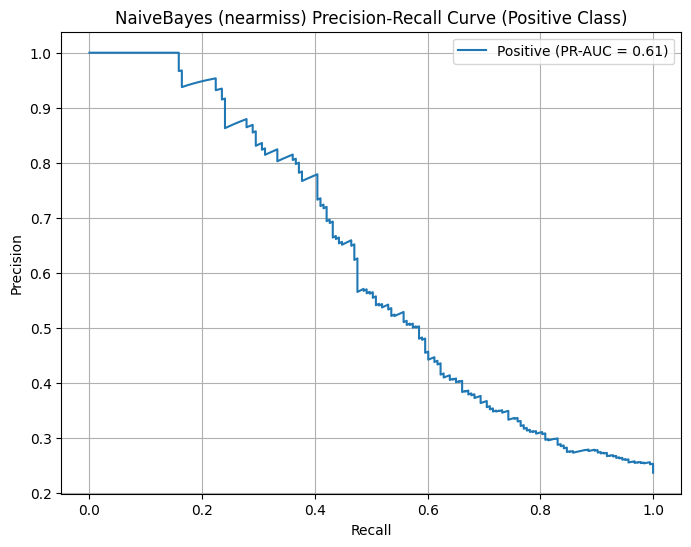

2025-06-23 19:58:41,781 - INFO - Saved PR curve: NaiveBayes_nearmiss_pr_curve.png
2025-06-23 19:58:41,784 - INFO - Loaded model: NaiveBayes_weighted_tuned.joblib


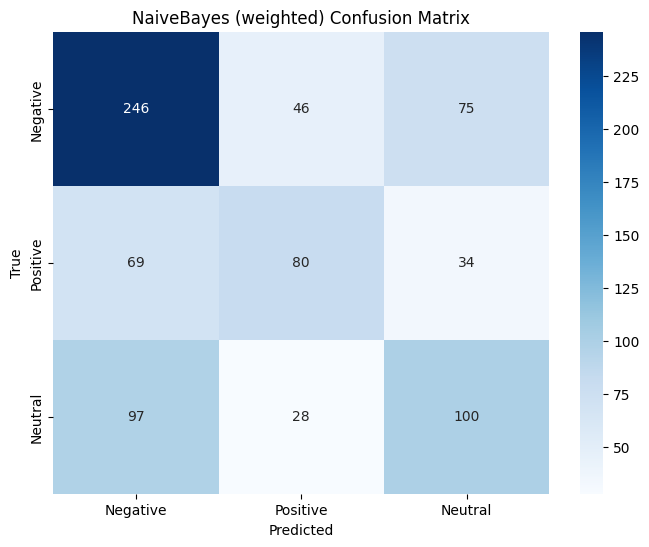

2025-06-23 19:58:42,416 - INFO - Saved confusion matrix: NaiveBayes_weighted_cm.png


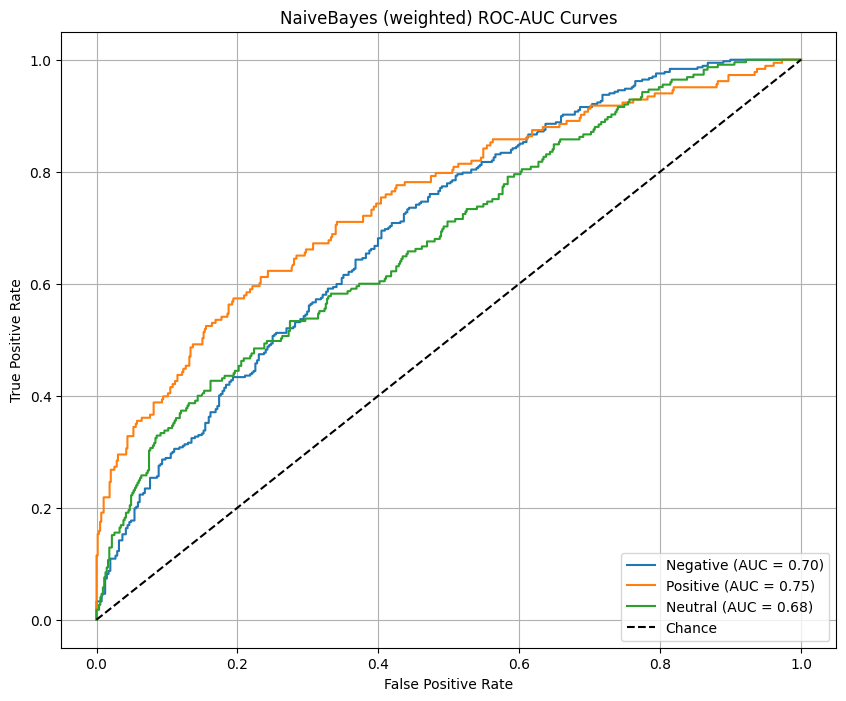

2025-06-23 19:58:42,971 - INFO - Saved ROC-AUC plot: NaiveBayes_weighted_roc_auc.png


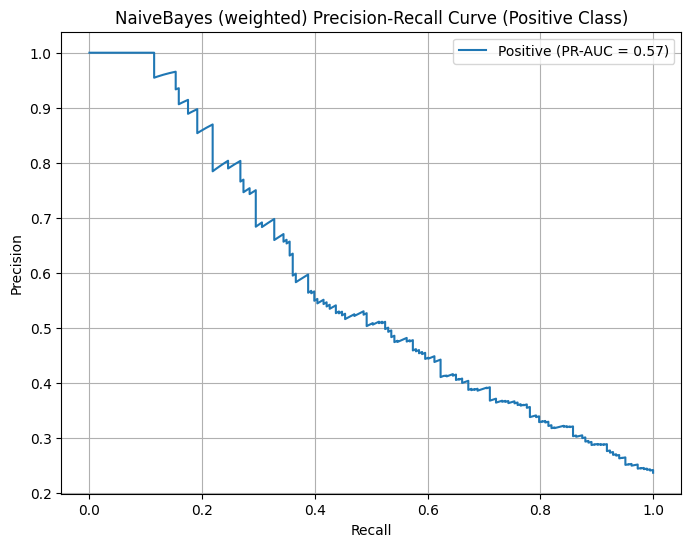

2025-06-23 19:58:43,563 - INFO - Saved PR curve: NaiveBayes_weighted_pr_curve.png
Evaluating Models:  75%|███████▌  | 3/4 [00:16<00:05,  5.89s/it]2025-06-23 19:58:44,107 - INFO - Loaded model: RandomForest_smote_tuned.joblib


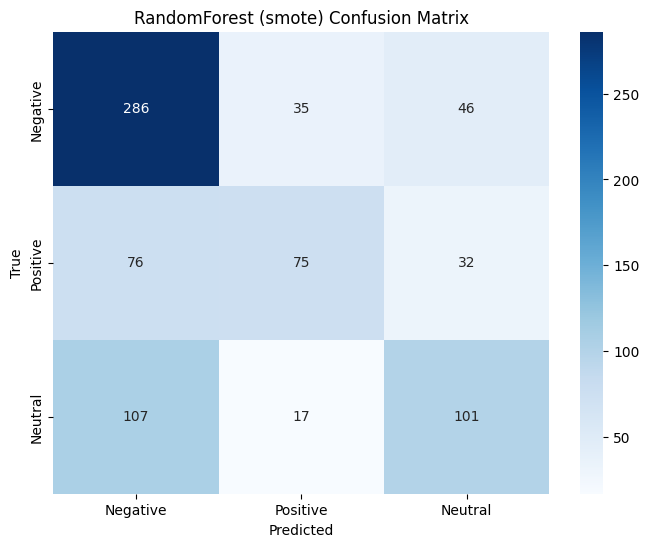

2025-06-23 19:58:44,760 - INFO - Saved confusion matrix: RandomForest_smote_cm.png


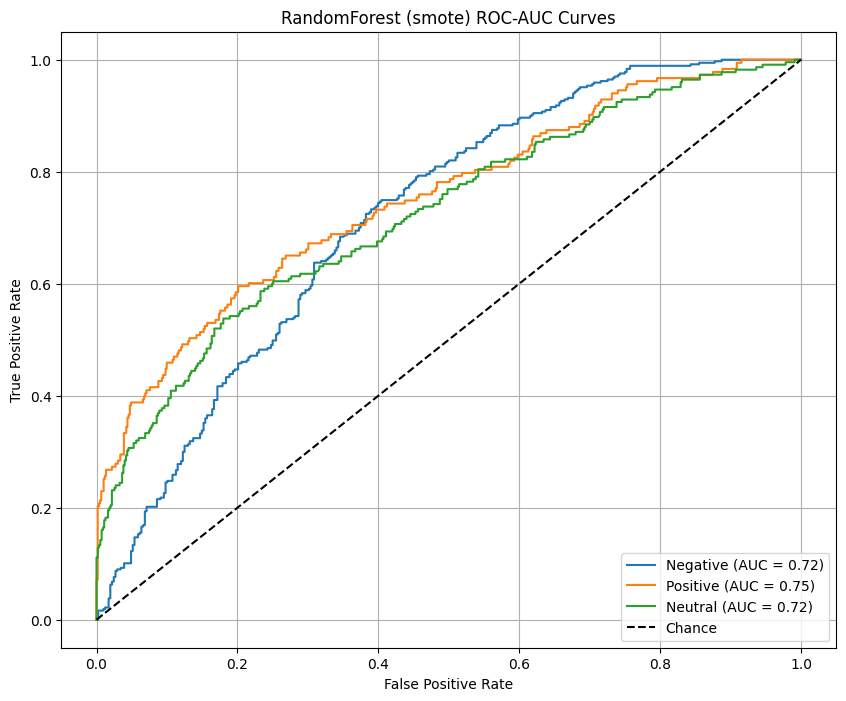

2025-06-23 19:58:45,170 - INFO - Saved ROC-AUC plot: RandomForest_smote_roc_auc.png


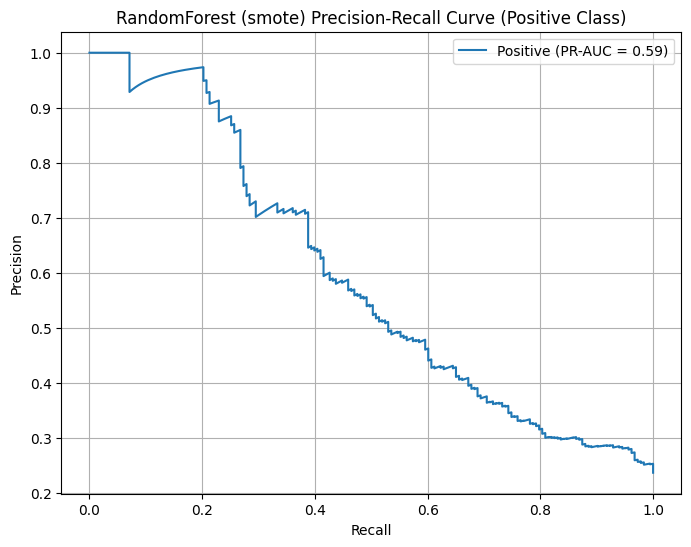

2025-06-23 19:58:45,518 - INFO - Saved PR curve: RandomForest_smote_pr_curve.png
2025-06-23 19:58:45,698 - INFO - Loaded model: RandomForest_undersampled_tuned.joblib


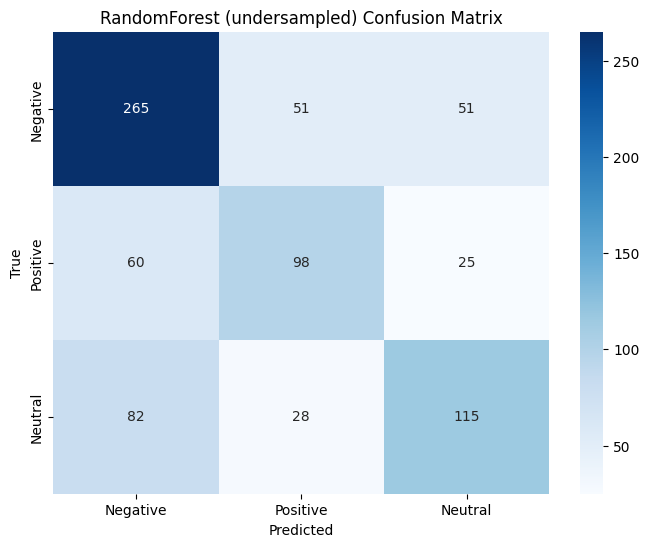

2025-06-23 19:58:46,154 - INFO - Saved confusion matrix: RandomForest_undersampled_cm.png


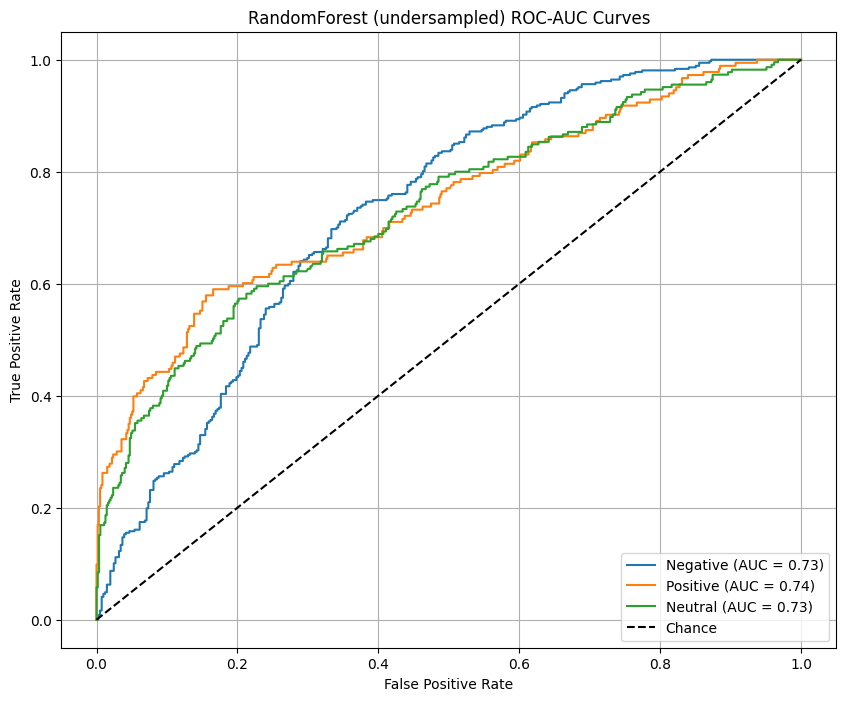

2025-06-23 19:58:46,543 - INFO - Saved ROC-AUC plot: RandomForest_undersampled_roc_auc.png


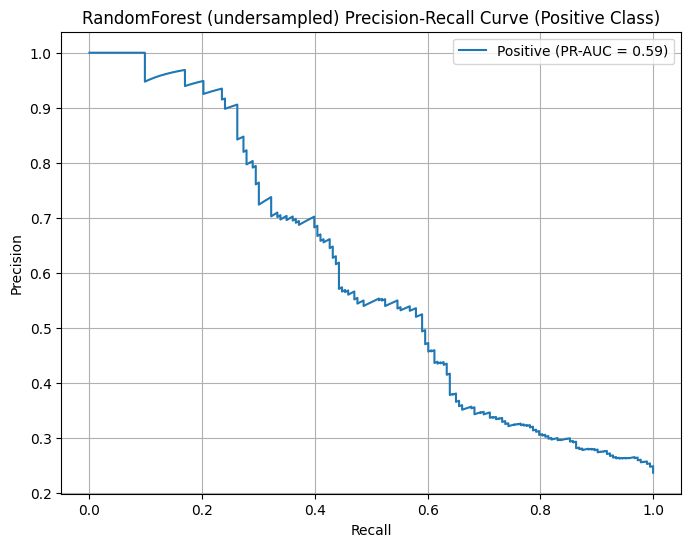

2025-06-23 19:58:46,954 - INFO - Saved PR curve: RandomForest_undersampled_pr_curve.png
2025-06-23 19:58:47,106 - INFO - Loaded model: RandomForest_nearmiss_tuned.joblib


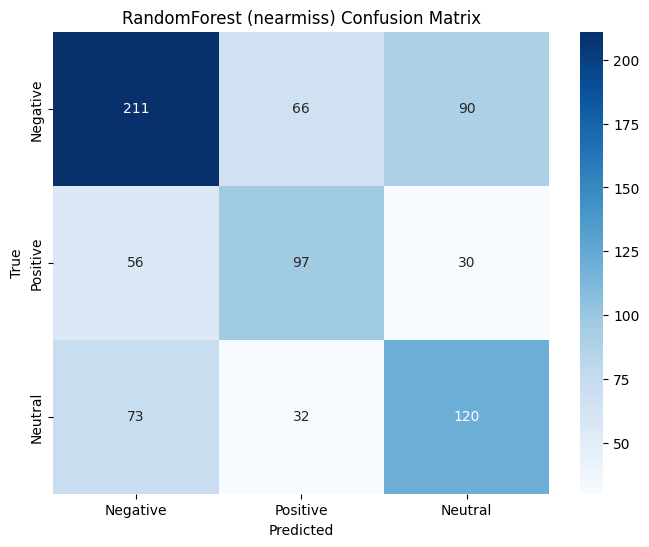

2025-06-23 19:58:47,552 - INFO - Saved confusion matrix: RandomForest_nearmiss_cm.png


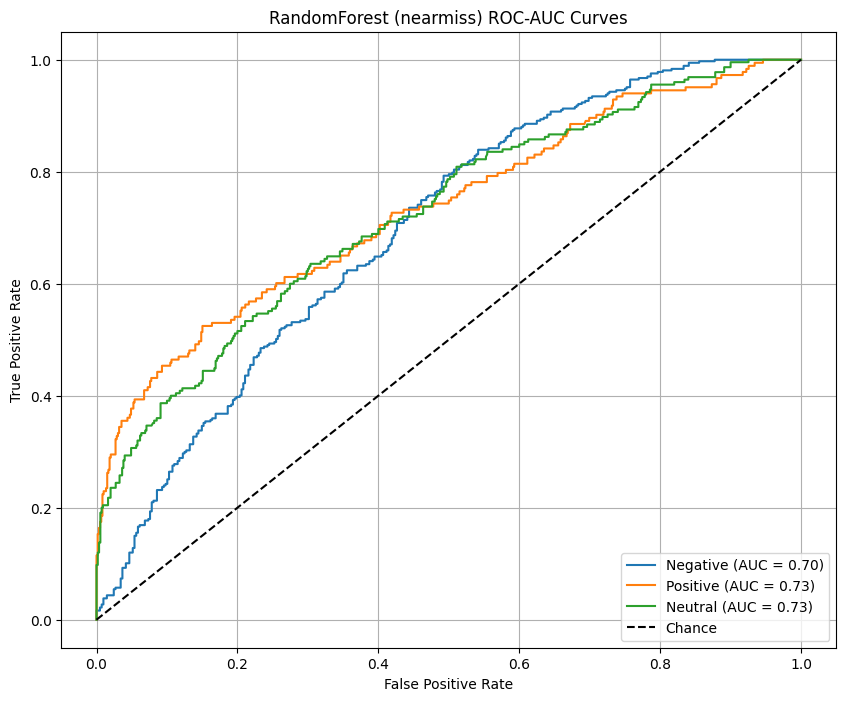

2025-06-23 19:58:48,036 - INFO - Saved ROC-AUC plot: RandomForest_nearmiss_roc_auc.png


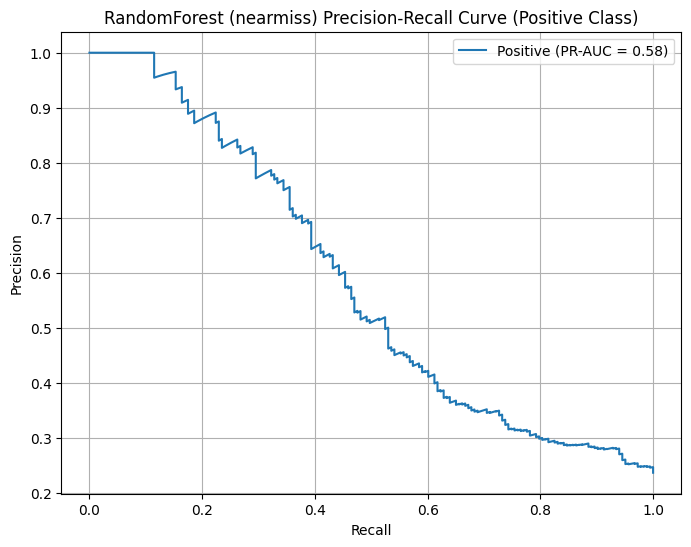

2025-06-23 19:58:48,369 - INFO - Saved PR curve: RandomForest_nearmiss_pr_curve.png
2025-06-23 19:58:48,778 - INFO - Loaded model: RandomForest_weighted_tuned.joblib


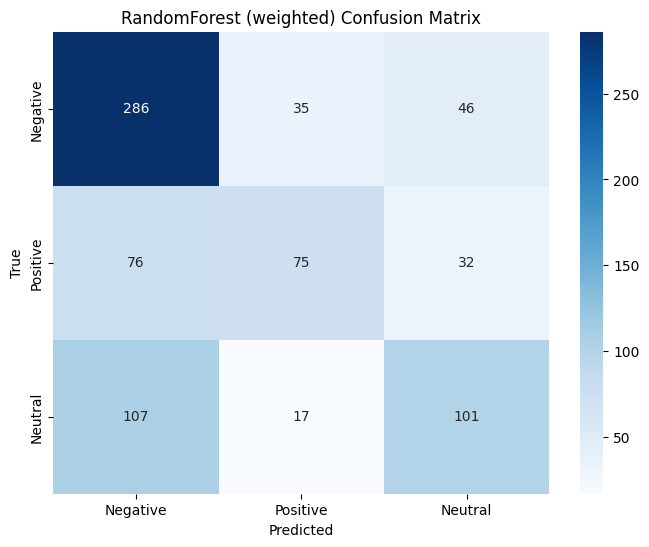

2025-06-23 19:58:49,296 - INFO - Saved confusion matrix: RandomForest_weighted_cm.png


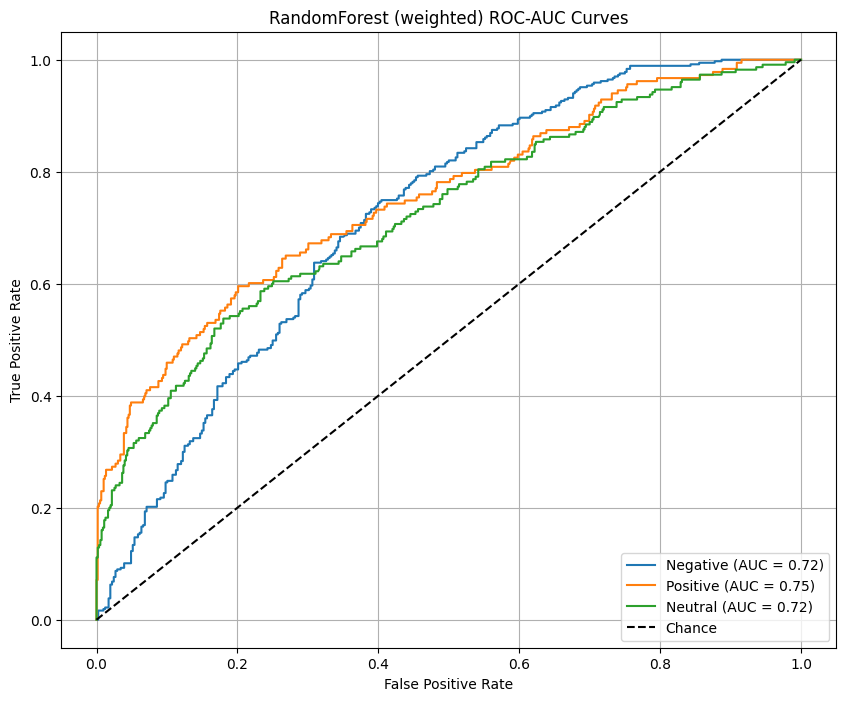

2025-06-23 19:58:49,730 - INFO - Saved ROC-AUC plot: RandomForest_weighted_roc_auc.png


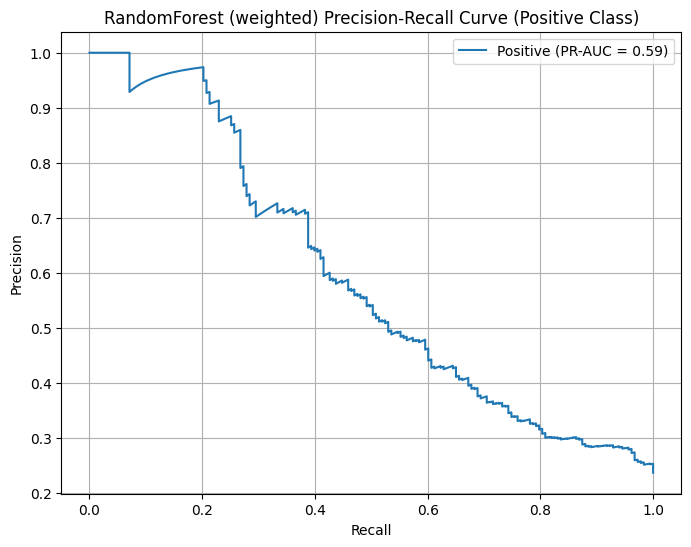

2025-06-23 19:58:50,191 - INFO - Saved PR curve: RandomForest_weighted_pr_curve.png
Evaluating Models: 100%|██████████| 4/4 [00:23<00:00,  5.90s/it]
2025-06-23 19:58:50,546 - INFO - Saved F1 comparison plot
2025-06-23 19:58:50,862 - INFO - Saved PR-AUC comparison plot
2025-06-23 19:58:50,865 - INFO - Test results saved: test_results.csv


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support,
    auc,
    precision_recall_curve
)
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import joblib
import logging

# Define class names
class_names = ['Negative', 'Positive', 'Neutral']

# Initialize results
f1_scores = {'Model': [], 'Mitigation': [], 'F1_Weighted': [], 'F1_Negative': [], 'F1_Positive': [], 'F1_Neutral': [], 'PR_AUC_Positive': []}
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

# Evaluate models
for name in tqdm(['LogisticRegression', 'SVM', 'NaiveBayes', 'RandomForest'], desc="Evaluating Models: "):
    for dataset_name in ['smote', 'undersampled', 'nearmiss', 'weighted']:
        try:
            model = joblib.load(f"models/mitigated_models/{name}_{dataset_name}_tuned.joblib")
            logging.info(f"Loaded model: {name}_{dataset_name}_tuned.joblib")
            y_pred = model.predict(tfidf_test)
            y_pred_proba = model.predict_proba(tfidf_test)

            # Compute metrics
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            f1_per_class = precision_recall_fscore_support(y_test, y_pred)[2]
            precision_positive, recall_positive, _ = precision_recall_curve(y_test_bin[:, 1], y_pred_proba[:, 1])
            pr_auc_positive = auc(recall_positive, precision_positive)

            # Store results
            f1_scores['Model'].append(name)
            f1_scores['Mitigation'].append(dataset_name)
            f1_scores['F1_Weighted'].append(f1)
            f1_scores['F1_Negative'].append(f1_per_class[0])
            f1_scores['F1_Positive'].append(f1_per_class[1])
            f1_scores['F1_Neutral'].append(f1_per_class[2])
            f1_scores['PR_AUC_Positive'].append(pr_auc_positive)

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
            plt.title(f"{name} ({dataset_name}) Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.savefig(f"models/mitigated_models/{name}_{dataset_name}_cm.png")
            plt.show()
            plt.close()
            logging.info(f"Saved confusion matrix: {name}_{dataset_name}_cm.png")

            # ROC-AUC Curve
            plt.figure(figsize=(10, 8))
            for i in range(len(class_names)):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
                auc_score = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
                plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")
            plt.plot([0, 1], [0, 1], 'k--', label='Chance')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f"{name} ({dataset_name}) ROC-AUC Curves")
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.savefig(f"models/mitigated_models/{name}_{dataset_name}_roc_auc.png")
            plt.show()
            plt.close()
            logging.info(f"Saved ROC-AUC plot: {name}_{dataset_name}_roc_auc.png")

            # Precision-Recall Curve for Positive Class
            plt.figure(figsize=(8, 6))
            plt.plot(recall_positive, precision_positive, label=f'Positive (PR-AUC = {pr_auc_positive:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f"{name} ({dataset_name}) Precision-Recall Curve (Positive Class)")
            plt.legend()
            plt.grid(True)
            plt.savefig(f"models/mitigated_models/{name}_{dataset_name}_pr_curve.png")
            plt.show()
            plt.close()
            logging.info(f"Saved PR curve: {name}_{dataset_name}_pr_curve.png")
        except Exception as e:
            logging.error(f"Error evaluating {name} ({dataset_name}): {str(e)}")

# Plot comparisons
f1_df = pd.DataFrame(f1_scores)
sns.barplot(x='Mitigation', y='F1_Weighted', hue='Model', data=f1_df)
plt.title("Weighted F1 Comparison Across Mitigation Strategies")
plt.savefig("models/mitigated_models/f1_comparison_weighted.png")
plt.close()
logging.info("Saved F1 comparison plot")

sns.barplot(x='Mitigation', y='PR_AUC_Positive', hue='Model', data=f1_df)
plt.title("Precision-Recall AUC (Positive Class) Comparison")
plt.savefig("models/mitigated_models/pr_auc_positive_comparison.png")
plt.close()
logging.info("Saved PR-AUC comparison plot")

# Save results
f1_df.to_csv("models/mitigated_models/test_results.csv")
logging.info("Test results saved: test_results.csv")

In [11]:
# Update README
with open("models/mitigated_models/README.txt", "w", encoding='utf-8') as f:
    f.write("Mitigated Model Outputs:\n"
            "- mitigated_datasets/*.npz, *.csv: SMOTE, Undersampled, NearMiss datasets\n"
            "- models/mitigated_models/*_*.joblib: Trained models\n"
            "- models/mitigated_models/*_tuned.joblib: Tuned models\n"
            "- tuned_results.csv: Tuning results\n"
            "- test_results.csv: Test set metrics\n"
            "- *_cm.png: Confusion matrices\n"
            "- *_roc_auc.png: ROC-AUC curves\n"
            "- *_pr_curve.png: Precision-recall curves\n"
            "- f1_comparison_*.png: F1 comparison plots\n"
            "- pr_auc_positive_comparison.png: PR-AUC comparison")
logging.info("README updated")

2025-06-23 19:59:24,966 - INFO - README updated
